In [1]:
import pandas as pd
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
# Load the saved data
df = pd.read_csv('../data/reddit_posts.csv')

# Combine title and selftext into a single text field
df['selftext'] = df['selftext'].fillna('')
df['text'] = df['title'] + ' ' + df['selftext']

# Drop rows where text is empty after combining
df = df[df['text'].str.strip().astype(bool)]

# Reset index
df.reset_index(drop=True, inplace=True)

# Preview result
df[['subreddit', 'text']].head()

,subreddit,text
0,science,A new study across 11 African reserves found t...
1,science,Low-calorie diets might increase risk of depre...
2,science,People around the world are more likely to fav...
3,science,Self-perceived physical attractiveness linked ...
4,science,Efficient mRNA delivery to resting T cells to ...


In [3]:
def clean_text(text):
    text = text.lower()
    # remove URLs
    text = re.sub(r'http\S+', '', text)
    # remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_text'] = df['text'].apply(clean_text)

# Preview cleaned text
df[['subreddit', 'clean_text']].head()

,subreddit,clean_text
0,science,a new study across african reserves found that...
1,science,lowcalorie diets might increase risk of depres...
2,science,people around the world are more likely to fav...
3,science,selfperceived physical attractiveness linked t...
4,science,efficient mrna delivery to resting t cells to ...


In [4]:
# Load spaCy English model
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.lemma_ not in STOP_WORDS]
    return ' '.join(tokens)

# Apply preprocessing
df['processed_text'] = df['clean_text'].apply(preprocess_text)

# Preview final version
df[['subreddit', 'processed_text']].head()

,subreddit,processed_text
0,science,new study african reserve find dehorn rhino cu...
1,science,lowcalorie diet increase risk depression overw...
2,science,people world likely favor dominant authoritari...
3,science,selfperceived physical attractiveness link str...
4,science,efficient mrna delivery rest t cell reverse hi...


In [5]:
# Save processed dataset for modeling
df.to_csv('../data/reddit_preprocessed.csv', index=False)

In [6]:
# Word count per post
df['word_count'] = df['processed_text'].apply(lambda x: len(x.split()))

# Average word count by subreddit
avg_lengths = df.groupby('subreddit')['word_count'].mean()
print("Average word count per post:")
print(avg_lengths)

# Most common words overall

all_words = ' '.join(df['processed_text']).split()
common_words = Counter(all_words).most_common(20)
print("\nTop 20 words:")
for word, count in common_words:
    print(f"{word}: {count}")

Average word count per post:
subreddit
science       17.616711
technology     9.095471
Name: word_count, dtype: float64

Top 20 words:
new: 255
study: 249
ai: 232
find: 189
use: 133
people: 109
risk: 82
researcher: 82
brain: 72
high: 70
time: 69
scientist: 69
research: 68
trump: 68
human: 67
health: 64
year: 62
age: 62
link: 57
cancer: 56


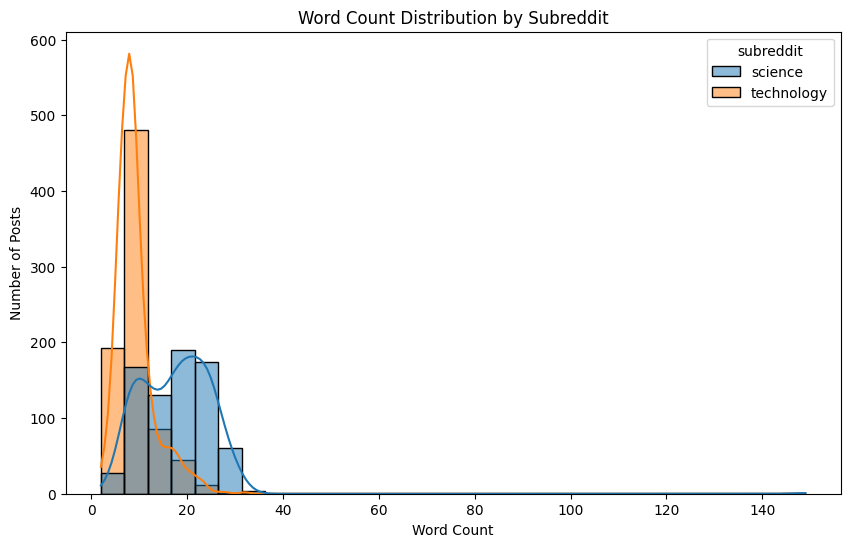

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='word_count', hue='subreddit', bins=30, kde=True)
plt.title('Word Count Distribution by Subreddit')
plt.xlabel('Word Count')
plt.ylabel('Number of Posts')
plt.show()

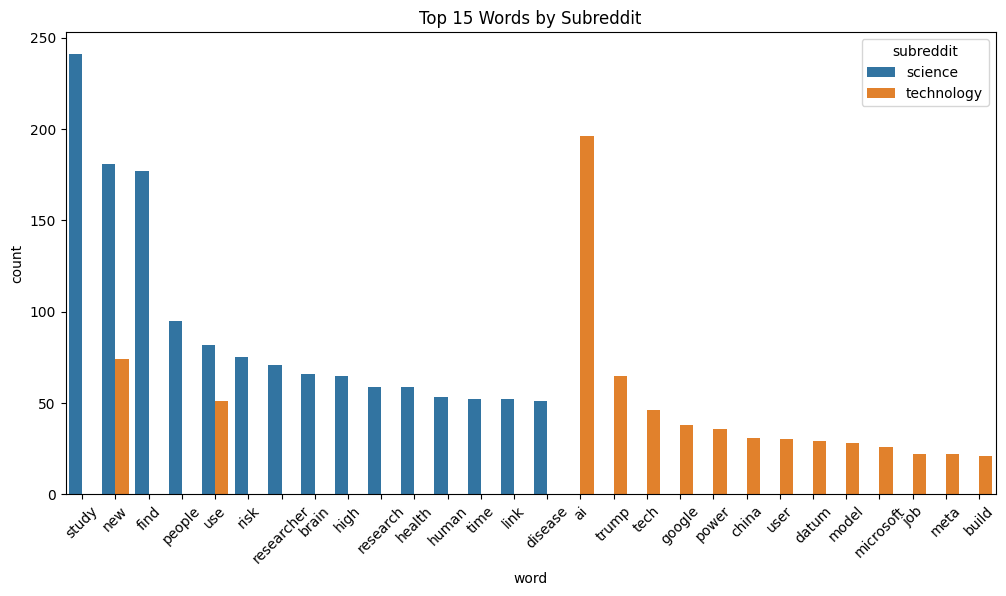

In [8]:
def top_words_by_group(group_df, n=15):
    words = ' '.join(group_df['processed_text']).split()
    return Counter(words).most_common(n)

# Get top words for each subreddit
science_top = top_words_by_group(df[df['subreddit'] == 'science'])
tech_top = top_words_by_group(df[df['subreddit'] == 'technology'])

# Turn into DataFrame for plotting
science_df = pd.DataFrame(science_top, columns=['word', 'count'])
science_df['subreddit'] = 'science'

tech_df = pd.DataFrame(tech_top, columns=['word', 'count'])
tech_df['subreddit'] = 'technology'

top_words_df = pd.concat([science_df, tech_df])

# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_words_df, x='word', y='count', hue='subreddit')
plt.title('Top 15 Words by Subreddit')
plt.xticks(rotation=45)
plt.show()

In [9]:
# Generate text for each group
science_text = ' '.join(df[df['subreddit'] == 'science']['processed_text'])
tech_text = ' '.join(df[df['subreddit'] == 'technology']['processed_text'])

# Set up WordCloud config
wc = WordCloud(width=800, height=400, background_color='white', max_words=100)

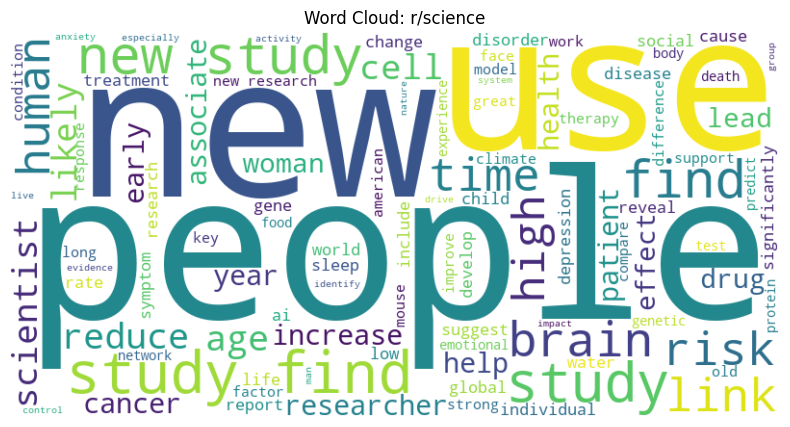

In [10]:
# Create and show science word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wc.generate(science_text), interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: r/science')
plt.show()

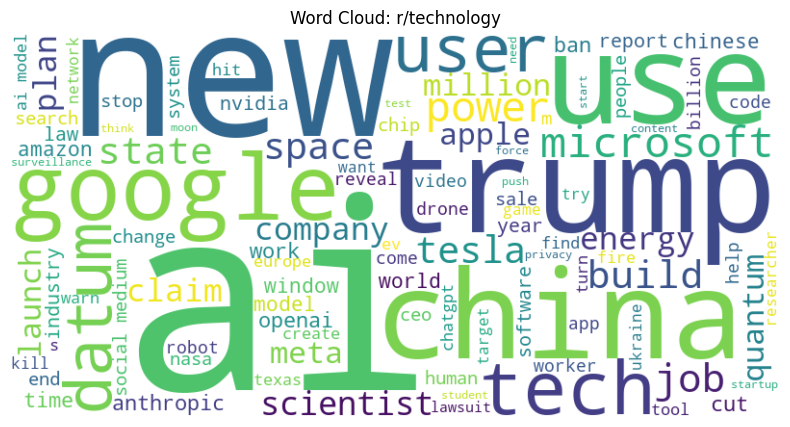

In [11]:
# Create and show technology word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wc.generate(tech_text), interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: r/technology')
plt.show()